# Descripción del proyecto

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

# Instrucciones del proyecto

1. Descarga y prepara los datos.Explica el procedimiento.
2. Examina el equilibrio de clases. Entrena el modelo sin tener en cuenta el desequilibrio. - Describe brevemente tus hallazgos.
3. Mejora la calidad del modelo. Asegúrate de utilizar al menos dos enfoques para corregir el desequilibrio de clases. Utiliza conjuntos de entrenamiento y validación para encontrar el mejor modelo y el mejor conjunto de parámetros. Entrena diferentes modelos en los conjuntos de entrenamiento y validación. Encuentra el mejor. Describe brevemente tus hallazgos.
4. Realiza la prueba final.

# Descripción de los datos

Puedes encontrar los datos en el archivo  /datasets/Churn.csv file. Descarga el conjunto de datos.

## Características

- RowNumber: índice de cadena de datos
- CustomerId: identificador de cliente único
- Surname: apellido
- CreditScore: valor de crédito
- Geography: país de residencia
- Gender: sexo
- Age: edad
- Tenure: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
- Balance: saldo de la cuenta
- NumOfProducts: número de productos bancarios utilizados por el cliente
- HasCrCard: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
- IsActiveMember: actividad del cliente (1 - sí; 0 - no)
- EstimatedSalary: salario estimado

## Objetivo

- Exited: El cliente se ha ido (1 - sí; 0 - no)

## Librerías

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from pprint import pprint
from scipy.stats import randint
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)
from sklearn.metrics import classification_report

## Carga de datos

In [69]:
data=pd.read_csv('datasets/Churn.csv')
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [71]:
#Pasamos las columnas al modo snake_case
data.columns=['Row_Number', 'Customer_Id', 'Surname', 'Credit_Score', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'Num_Of_Products', 'Has_Cr_Card',
       'Is_Active_Member', 'Estimated_Salary', 'Exited']
new_col=[]
for i in data.columns:
    x=i.lower()
    new_col.append(x)
data.columns=new_col


In [72]:
data.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [73]:
#Cambiamos el tipo de dato a string
data['row_number']=data['row_number'].astype(str)
data['customer_id']=data['customer_id'].astype(str)
data['balance']=data['balance'].astype(int)
data['estimated_salary']=data['estimated_salary'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  object 
 1   customer_id       10000 non-null  object 
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  int32  
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  int32  
 13  exited            10000 non-null  int64  
dtypes: float64(1), int32(2), int64(6), object(5)
memory usage: 1015.8+ KB


Podemos ver a simple vista con el data info, que nuestros datos están bien, y que solo tenemos ausentes en la columna 'tenure', sin embargo, veremos más a fondo los ausetes y los duplicados.

En cuanto a los tipos de datos vemos que las columnas 'RowNumber' y 'CustomerId' deberían ser tipo string para no cometer errores con estos números que no son significativos, sin embargo, debido a que el objetivo del proyecto es predecir los clientes que se van del banco, las tres primeras columnas no son relevantes para entrenar el modelo, por lo que no se tendrán en cuenta.

## Limpieza de datos

In [74]:
#Calculamos los ausentes
print('Ausentes: \n',data.isna().sum())

Ausentes: 
 row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64


In [75]:
#Calculamos el porcentaje de significancia de los ausentes
print('Porcentaje de significancia: \n',100*data.isna().sum()/data.shape[0])

Porcentaje de significancia: 
 row_number          0.00
customer_id         0.00
surname             0.00
credit_score        0.00
geography           0.00
gender              0.00
age                 0.00
tenure              9.09
balance             0.00
num_of_products     0.00
has_cr_card         0.00
is_active_member    0.00
estimated_salary    0.00
exited              0.00
dtype: float64


Podeos ver que solo tenure tiene 909 ausentes el cual equivale al 9.09% de los datos, podemos trabajar con estos para imputarlos.

In [76]:
data[data['tenure'].isna()]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0,3,1,0,140469,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391,1,0,1,90878,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050,2,0,0,86424,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561,1,0,0,164040,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857,1,0,0,84509,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409,2,1,1,138361,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216,1,1,0,117369,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593,2,0,0,113308,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841,2,1,0,96833,0


In [77]:
#Llenamos los ausentes con la mediana
data['tenure'].fillna(data['tenure'].median(),inplace=True)
print(100*data.isna().sum()/data.shape[0])


row_number          0.0
customer_id         0.0
surname             0.0
credit_score        0.0
geography           0.0
gender              0.0
age                 0.0
tenure              0.0
balance             0.0
num_of_products     0.0
has_cr_card         0.0
is_active_member    0.0
estimated_salary    0.0
exited              0.0
dtype: float64


Llenamos los datos ausentes con la mediana.

In [78]:
print('Duplicados: \n',data.duplicated().sum())

Duplicados: 
 0


No tenemos duplicados, y rellenamos los ausentes, por lo cual estamos listos para comenzar el modelo de clasificación.

## Entrenamiento

### Examinamos el balanceo

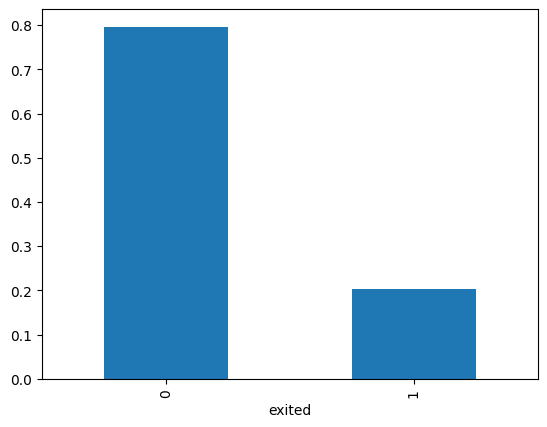

In [79]:
balance=data['exited'].value_counts(normalize=True)
plt=balance.plot(kind='bar')

### Escalado de caracteristicas

In [81]:
numeric=['credit_score','age','tenure','balance','num_of_products','has_cr_card','is_active_member','estimated_salary']
scaler=StandardScaler()
scaler.fit(data[numeric])
data[numeric]=scaler.transform(data[numeric])

Podemos ver que la clase "0" es predominante con un porcentaje aproximado del 80%, en cambio la clase "1" tiene solo el 20%

### Codificación de las variables categoricas para los arboles

Vamos a codificar con etiquetas el dataframe para los arboles y utilizaremos ONE-HOT para la regresion logística.

In [82]:
data.head(5)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,-0.326221,France,Female,0.293517,-1.086246,-1.225847,-0.911583,0.646092,0.970243,0.021880,1
1,2,15647311,Hill,-0.440036,Spain,Female,0.198164,-1.448581,0.117342,-0.911583,-1.547768,0.970243,0.216532,0
2,3,15619304,Onio,-1.536794,France,Female,0.293517,1.087768,1.333050,2.527057,0.646092,-1.030670,0.240686,1
3,4,15701354,Boni,0.501521,France,Female,0.007457,-1.448581,-1.225847,0.807737,-1.547768,-1.030670,-0.108920,0
4,5,15737888,Mitchell,2.063884,Spain,Female,0.388871,-1.086246,0.785723,-0.911583,0.646092,0.970243,-0.365269,0


In [83]:
#Usamos codificación de etiquetas para el modelo, debido a que usaremos un arbol de clasificación
data_model=data.drop(['customer_id','row_number','surname'],axis=1)
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data_model), columns=data_model.columns)
data_ordinal.head(5)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,4951.0,1.0
1,217.0,2.0,0.0,23.0,1.0,729.0,0.0,0.0,1.0,5506.0,0.0
2,111.0,0.0,0.0,24.0,8.0,5620.0,2.0,1.0,0.0,5572.0,1.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4595.0,0.0
4,459.0,2.0,0.0,25.0,2.0,3583.0,0.0,1.0,1.0,3834.0,0.0


In [84]:
#Codificamos los datos en one-hot para la regresion logistica
data_oh=pd.get_dummies(data_model,drop_first=True)
data_oh.head(5)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,-0.326221,0.293517,-1.086246,-1.225847,-0.911583,0.646092,0.970243,0.021880,1,False,False,False
1,-0.440036,0.198164,-1.448581,0.117342,-0.911583,-1.547768,0.970243,0.216532,0,False,True,False
2,-1.536794,0.293517,1.087768,1.333050,2.527057,0.646092,-1.030670,0.240686,1,False,False,False
3,0.501521,0.007457,-1.448581,-1.225847,0.807737,-1.547768,-1.030670,-0.108920,0,False,False,False
4,2.063884,0.388871,-1.086246,0.785723,-0.911583,0.646092,0.970243,-0.365269,0,False,True,False


### Separamos el dataset en entrenamiento y validación

In [85]:
#Separamos los datos para los arboles
seed=12345
features= data_ordinal.drop(['exited'],axis=1)
target=data_ordinal['exited']

features_train_ordinal, features_valid_ordinal, target_train_ordinal, target_valid_ordinal=train_test_split(
    features,target,random_state=seed,test_size=0.25)

model=RandomForestClassifier()

In [86]:
#Separamos los datos para la regresion logística
seed=12345
features= data_oh.drop(['exited'],axis=1)
target=data_oh['exited']

features_train_oh, features_valid_oh, target_train_oh, target_valid_oh=train_test_split(
    features,target,random_state=seed,test_size=0.25)

model=RandomForestClassifier()

### Random Forest

In [87]:
#Ahora vamos a pasar la lista de parametros que queremos iterar:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Número de features a considerar para cada separación
max_features = randint(1, 11)
# Máximo número de niveles a considerar en el arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Número mínimo  de pruebas requeridas para las eparación de un nodo
min_samples_split = [2, 5, 10]
# Número minimo de pruebas requeridas para cada nodo hoja
min_samples_leaf = [1, 2, 4]
# Metodo de selección de pruebas para el entrenamiento de cada árbol
bootstrap = [True, False]
# Creación de la malla aleatoria
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B3204ABB30>,
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [88]:
#Ahora junto con la malla y el RandomizedCV vamos a generar el mejor modelo con los mejores hiperparametros 
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=seed, n_jobs = -1)
# Entrenamos el modelo
model_random.fit(features_train_ordinal,target_train_ordinal)
print(model_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'bootstrap': True, 'max_depth': 110, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [89]:
best_random = model_random.best_estimator_
random_prediction = best_random.predict(features_valid_ordinal)
random_accuracy=metrics.accuracy_score(target_valid_ordinal,random_prediction)
print("Accuracy:",random_accuracy)

Accuracy: 0.8548


              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91      1965
         1.0       0.80      0.42      0.56       535

    accuracy                           0.85      2500
   macro avg       0.83      0.70      0.73      2500
weighted avg       0.85      0.85      0.84      2500



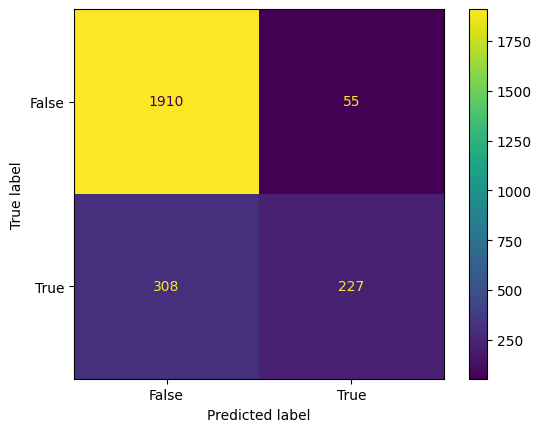

In [91]:
print(classification_report(target_valid_ordinal,random_prediction))
confusion_matrix = metrics.confusion_matrix(target_valid_ordinal,random_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

Podemos ver en la matriz que los datos están desbalanceados, debido a que el recall de la clase 1 es de 0.42 y el f1 es 0.56 lo que indica que del total dela suma de verdaderos positivos y falsos negativos, solo se está acertanco al 42% de los datos con categoría 1, por lo cual debemos hacer labores de balanceo para mejorar este resultado.

### Decision Tree

In [96]:
#Parametros del arbol de decisión
params = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
tree=DecisionTreeClassifier() 

In [99]:
#Iteramos para hallar los mejores hiperparametros para el arbol de decisión
random_tree=RandomizedSearchCV(estimator = tree, param_distributions = params, n_iter = 100, cv = 3, verbose=2, random_state=seed, n_jobs = -1)
# Entrenamos el modelo
random_tree.fit(features_train_ordinal,target_train_ordinal)
print(random_tree.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 5}


In [101]:
best_tree = random_tree.best_estimator_
tree_prediction = best_tree.predict(features_valid_ordinal)
tree_accuracy=metrics.accuracy_score(target_valid_ordinal,tree_prediction)
print("Accuracy:",tree_accuracy)

Accuracy: 0.8276


              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89      1965
         1.0       0.63      0.47      0.54       535

    accuracy                           0.83      2500
   macro avg       0.75      0.70      0.72      2500
weighted avg       0.81      0.83      0.82      2500



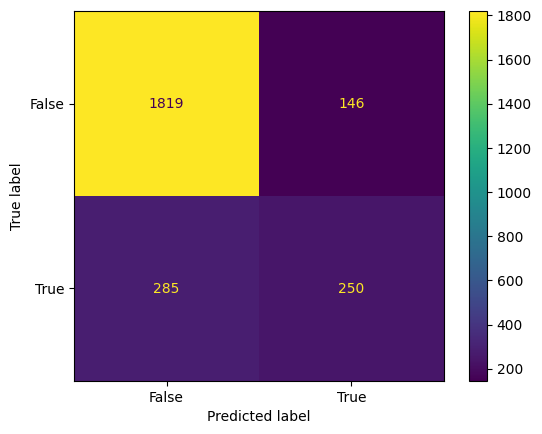

In [102]:
print(classification_report(target_valid_ordinal,tree_prediction))
confusion_matrix = metrics.confusion_matrix(target_valid_ordinal,tree_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

Al igual que el bosque aleatorio, podemos ver que el desbalanceo afecta el recall y el f1 score de la clase 1, con valores de 0.47 y 0.54 respectivamente, incluso en este caso la precisión se vio afectada al bajar a un 63%. También debemos trabajar con estos datos para contraarrestar el balanceo.